In [1]:
from binance.client import Client
import pandas as pd
# from gym_anytrading.envs import StocksEnv, ForexEnv
from stocks_env import StocksEnv
from stable_baselines3 import A2C,PPO,DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt
import quantstats as qs
import numpy
import os
import pandas_ta as ta
from pon import api,secret
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_price_data_binance(ticker:str,limit:int,start_str:str, end_str:str,interval = Client.KLINE_INTERVAL_1DAY)->pd.DataFrame:
    client = Client(api, secret)
    df = pd.DataFrame(client.get_historical_klines(symbol=ticker, interval=interval,start_str=start_str, end_str=end_str))
    df.columns=['date','Open','High','Low','Close','Volume','close_time','d1','d2','d3','d4','d5']
    df = df.drop(['close_time','d1','d2','d3','d4','d5'],axis=1)
    df['date'] = pd.to_datetime(df['date']*1000000)
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    # df.set_index('date',inplace=True)
    df['Volume'] = df['Volume'].apply(lambda x:round(float(x),2))
    return df

def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['PCTOpen','PCTHigh','PCTLow','PCTClose','PCTVolume','RSX','SLOPE']].to_numpy()[start:end]
    return prices, signal_features

class MyCustomEnv(StocksEnv):
    _process_data = add_signals


In [3]:
# traindf = get_price_data_binance('BTCUSDT',1000,'1 Jul, 2021','30 Nov, 2022',interval = Client.KLINE_INTERVAL_15MINUTE)
# testdf = get_price_data_binance('BTCUSDT',1000,'1 Dec, 2022','31 Dec, 2022',interval = Client.KLINE_INTERVAL_15MINUTE)
# traindf.to_csv('traindf.csv',index=False)
# testdf.to_csv('testdf.csv',index=False)
traindf = pd.read_csv('traindf.csv')
testdf = pd.read_csv('testdf.csv')
enddf = pd.read_csv('enddf.csv')
traindf['date'] = pd.to_datetime(traindf['date'])
testdf['date'] = pd.to_datetime(testdf['date'])
enddf['date'] = pd.to_datetime(enddf['date'])
traindf.set_index('date',inplace=True)
testdf.set_index('date',inplace=True)
enddf.set_index('date',inplace=True)

In [4]:
traindf['RSX'] = ta.rsx(traindf['Close'],21)
testdf['RSX'] = ta.rsx(testdf['Close'],21)
enddf['RSX'] = ta.rsx(enddf['Close'],21)

# traindf['AO'] = ta.ao(traindf['High'],traindf['Low'])
# testdf['AO'] = ta.ao(testdf['High'],testdf['Low'])

# traindf['BOP'] = ta.bop(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'])
# testdf['BOP'] = ta.bop(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'])

# traindf['CMO'] = ta.cmo(traindf['Close'])
# testdf['CMO'] = ta.cmo(testdf['Close'])

# traindf['CTI'] = ta.cti(traindf['Close'])
# testdf['CTI'] = ta.cti(testdf['Close'])

# traindf['ER'] = ta.er(traindf['Close'])
# testdf['ER'] = ta.er(testdf['Close'])

traindf['SLOPE'] = ta.slope(traindf['Close'],200)
testdf['SLOPE']= ta.slope(testdf['Close'],200)
enddf['SLOPE']= ta.slope(enddf['Close'],200)


# traindf['hammer'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="hammer")
# traindf['shootingstar'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="shootingstar")
# testdf['hammer'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="hammer")
# testdf['shootingstar'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="shootingstar")

# traindf['invertedhammer'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="invertedhammer")
# traindf['hangingman'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="hangingman")
# testdf['invertedhammer'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="invertedhammer")
# testdf['hangingman'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="hangingman")

# traindf['gravestonedoji'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="gravestonedoji")
# traindf['dragonflydoji'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="dragonflydoji")
# testdf['gravestonedoji'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="gravestonedoji")
# testdf['dragonflydoji'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="dragonflydoji")

# traindf['marubozu'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="marubozu")
# testdf['marubozu'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="marubozu")

# traindf[['hammer', 'shootingstar']] = traindf[['hammer', 'shootingstar']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# traindf[['invertedhammer', 'hangingman']] = traindf[['invertedhammer', 'hangingman']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# traindf[['gravestonedoji', 'dragonflydoji']] = traindf[['gravestonedoji', 'dragonflydoji']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# traindf[['marubozu']] = traindf[['marubozu']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)

# testdf[['hammer', 'shootingstar']] = testdf[['hammer', 'shootingstar']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# testdf[['invertedhammer', 'hangingman']] = testdf[['invertedhammer', 'hangingman']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# testdf[['gravestonedoji', 'dragonflydoji']] = testdf[['gravestonedoji', 'dragonflydoji']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# testdf[['marubozu']] = testdf[['marubozu']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
#Awesome Oscillator: ao,Balance of Power: bop,Chande Momentum Oscillator: cmo,Correlation Trend Indicator: cti,Efficiency Ratio: er.
#Moving Average Convergence Divergence: macd,Schaff Trend Cycle: stc, Slope: slope, Stochastic Oscillator: stoch, Stochastic RSI: stochrsi
#Trix: trix


traindf['PCTOpen'] = traindf['Open'].pct_change()
traindf['PCTHigh'] = traindf['High'].pct_change()
traindf['PCTLow'] = traindf['Low'].pct_change()
traindf['PCTClose'] = traindf['Close'].pct_change()
traindf['PCTVolume'] = traindf['Volume'].pct_change()

testdf['PCTOpen'] = testdf['Open'].pct_change()
testdf['PCTHigh'] = testdf['High'].pct_change()
testdf['PCTLow'] = testdf['Low'].pct_change()
testdf['PCTClose'] = testdf['Close'].pct_change()
testdf['PCTVolume'] = testdf['Volume'].pct_change()

enddf['PCTOpen'] = enddf['Open'].pct_change()
enddf['PCTHigh'] = enddf['High'].pct_change()
enddf['PCTLow'] = enddf['Low'].pct_change()
enddf['PCTClose'] = enddf['Close'].pct_change()
enddf['PCTVolume'] = enddf['Volume'].pct_change()

In [5]:
modelname = 'test10'
log_path = os.path.join('logs')
model_path = os.path.join('models',f'{modelname}')
# stats_path = os.path.join(log_path, "vec_normalize.pkl")
window_size = 50
start_index = window_size
end_index = len(enddf)
num_cpu = 1


# env = MyCustomEnv(df=traindf, frame_bound=(start_index+50,end_index), window_size=window_size)
# env.action_space

# obs = env.reset()
# action = env.action_space.sample()
# print(obs.dtype)


In [6]:
# model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path,learning_rate=3e-3)
# TIMESTEPS = 10000
# for i in range(1,1):
#     model.learn(total_timesteps=TIMESTEPS,reset_num_timesteps=False,tb_log_name=modelname)
#     model.save(os.path.join(f'{model_path}',f'{TIMESTEPS*i}'))

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


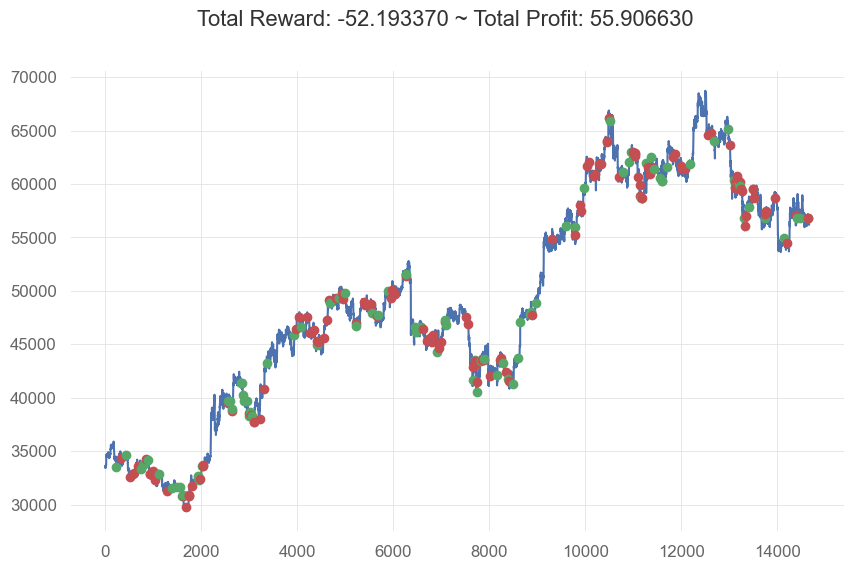

In [7]:
env = MyCustomEnv(df=traindf, frame_bound=(start_index+202,end_index), window_size=window_size)

profit = []
results = []
model = PPO.load('models\\test146\\170000.zip',env=env)

obs = env.reset()

while True:
    action, state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    results.append(info['total_profit'])
    # rewards.append(reward)
    if done:
        break
    # profit.append(info['total_profit'])
# print(info['total_profit'])
plt.cla()
env.render_all()
plt.show()
# plt.scatter(range(len(rewards)), rewards)
# plt.show()


In [8]:
# results = {'deposit':results}
# results = pd.DataFrame(results)
# qs.extend_pandas()

# net_worth = pd.Series(results['deposit'].values, index=traindf.index[start_index+51:end_index])
# returns = net_worth.iloc[1:]
# qs.reports.full(returns)